In [1]:
import os
import random
import re
import math
import numpy as np
import torch
import torch.nn as nn
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from os.path import join as pjoin
from transformers import CLIPTextModel, CLIPTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence 
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup
import PoseTransformer
# from PoseTransformer import PoseTransformer, CrossModalTransformer
from NoiseScheduler import NoiseScheduler

mp.set_start_method("spawn", force=True)

BATCH_SIZE = 8
ACCUMULATION_STEPS = 16
EPOCHS = 12
SAVE_PATH = "model_output"

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-1
PERCENT_TRAIN = 0.865

EMBEDDING_DIM = 512 
POSE_FEATURES_DIM = 263
LATENT_DIM = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\Kelvin C\.conda\envs\machine_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
src_dir = "..\\HumanML3D"
train_list = open(pjoin(src_dir, "train.txt"), "r", encoding="utf-8")
val_list = open(pjoin(src_dir, "val.txt"), "r", encoding="utf-8")
test_list = open(pjoin(src_dir, "test.txt"), "r", encoding="utf-8")

clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_text_model.eval()
for p in clip_text_model.parameters():
    p.requires_grad = False

In [3]:
class ResidualMLPBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim),
        )
    def forward(self, x):
        return x + self.net(x)

class Encoder(nn.Module):
    # ... (Same definition as in AE training script)
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    # ... (Same definition as in AE training script)
     def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, output_dim)
        )
     def forward(self, x): return self.net(x)

class Autoencoder(nn.Module):
     def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
     def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

In [4]:
def fourier_embedding(x, num_frequencies=10):
    """
    Applies Fourier feature encoding to the input tensor.
    x: (seq_len, 3) - The trajectory data (X, Y, Z)
    num_frequencies: The number of frequency bands
    """
    seq_len, dim = x.shape  # dim = 3 (X, Y, Z)
    
    # Define frequency bands: log-spaced
    freqs = torch.logspace(0.0, np.log10(1000.0), num_frequencies)  # Frequencies in range [1, 1000]
    
    # Compute sin and cos embeddings for each frequency
    x_proj = x.unsqueeze(-1) * freqs  # Shape: (seq_len, 3, num_frequencies)
    fourier_features = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)  # (seq_len, 3, 2*num_frequencies)
    
    return fourier_features.view(seq_len, -1)  # Flatten to (seq_len, 3 * 2 * num_frequencies)

class PoseTextDataset(Dataset):
    """
        (data_dir): contains all the new_joint_vecs
        (train_list): the train.txt, as an opened file
        (max_len): max length of text descriptions
    """

    def __init__(self, src_dir, setting, tokenizer, joint_num, use_percentage = 1.0):
        self.src_dir = src_dir
        self.tokenizer = tokenizer
        self.joint_num = joint_num 
        self.pose_features_dim = POSE_FEATURES_DIM

        if setting not in ["train", "train_temp", "val", "test", "all"]:
            print("Invalid setting. Must be train, val, test, or all.")
            raise

        with open(pjoin(src_dir, f"{setting}.txt"), "r") as f:
            self.file_list = [line.strip() for line in f.readlines()]

        if 0 < use_percentage < 1.0:
            random.shuffle(self.file_list)
            num_samples = int(len(self.file_list) * use_percentage)
            self.file_list = self.file_list[:num_samples]

        # get stats to normalize data later on
        self.mean, self.std = None, None
        stats = np.load("pose_stats.npz")
        self.mean = torch.tensor(stats['mean'], dtype=torch.float32).unsqueeze(0) # Shape (1, pose_features_dim)
        self.std = torch.tensor(stats['std'], dtype=torch.float32).unsqueeze(0)   # Shape (1, pose_features_dim)

    def __len__(self):
        return len(self.file_list)
 
    def __getitem__(self, index):
        file = self.file_list[index]

        # Load pose data
        pose_path = pjoin(self.src_dir, "new_joint_vecs", f"{file}.npy")
        pose_data = np.load(pose_path)  # Shape: (frames, joints, features)
        pose_tensor = torch.tensor(pose_data, dtype=torch.float32)
        # normalize
        pose_tensor_normalized = (pose_tensor - self.mean) / self.std

        # Load text description
        text_path = pjoin(self.src_dir, "texts", f"{file}.txt")

        # The descriptions have a extra information such as time stamp and part of speech. I will get rid of that for now to keep things simple.
        with open(text_path, "r", encoding="utf-8") as f:
            text_descriptions = [
                re.split('#', line.strip())[0] for line in f.readlines() if line.strip()
            ]

        # encoded_texts = self.tokenizer(
        #     text_descriptions,
        #     truncation=True,
        #     padding="max_length",
        #     max_length=
        # _len,
        #     return_tensors="pt"
        # )

        # Since tokenizer returns tensors in a dictionary, we can access them directly
        # input_ids = encoded_texts["input_ids"]
        # attention_mask = encoded_texts["attention_mask"]

        # world_joints = recover_from_ric(torch.from_numpy(pose_data).float(), self.joint_num)
        # root_positions = world_joints[:, 0, :] # get trajectory from root position
        # fourier_encoded_traj = fourier_embedding(root_positions)

        # Return a list of dictionaries, one per description
        return [{
            "pose": pose_tensor_normalized,
            "text": text,
            # "text": input_ids[i],
            # "attention_mask": attention_mask[i],
            # "trajectory": fourier_encoded_traj
        } for text in text_descriptions]

def collate_fn(batch):
    """
    Pads all pose sequences to the maximum length in the batch.
    """
    flattened_batch = [item for sublist in batch for item in sublist]
    
    # Extract poses and text descriptions from the batch
    poses = [item["pose"] for item in flattened_batch]  # List of pose tensors
    padded_poses = pad_sequence(poses, batch_first=True, padding_value=0.0)  # Shape: (batch_size, max_len, ...)
    pose_key_padding = (padded_poses.sum(-1) == 0)  

    # trajectories = [item["trajectory"] for item in flattened_batch]  # Fourier-encoded trajectories (varied lengths)
    # Pad trajectory sequences (pad with zeros to max length in the batch)
    # padded_trajectories = pad_sequence(trajectories, batch_first=True, padding_value=0.0)  # Shape: (batch_size, max_traj_len, fourier_dim)

    texts = [item["text"] for item in flattened_batch]  # List of tokenized text tensors
    tokenized = clip_tokenizer(
        texts,
        return_tensors="pt",
        padding=True,        # pad to longest in this *batch*
        truncation=True,
        max_length=None      # optional: drop any hard max
    )

    input_ids      = tokenized.input_ids
    attention_mask = tokenized.attention_mask

    return {
        "pose": padded_poses,
        "pose_mask": pose_key_padding,
        "text": input_ids,
        "attention_mask": attention_mask,
        # "trajectory": padded_trajectories,
        # trajectory_mask not needed as it shares the same dimensions as pose_mask
    }


In [5]:
class Trainer:
    def __init__(self, options, checkpoint_path = None):
        self.device = options['device']
        self.train_dataloader = options['train_dataloader']
        self.eval_dataloader = options['eval_dataloader']
        self.clip_text_model = options['clip_text_model']
        self.clip_tokenizer = options['clip_tokenizer']
        self.pose_transformer = options['pose_transformer']
        self.text_cross_transformer = options['text_cross_transformer']
        # self.trajectory_cross_transformer = options['trajectory_cross_transformer'].to(self.device)
        self.cfg_dropout_prob = options['cfg_dropout_prob']
        
        self.autoencoder = options['autoencoder']
        self.noise_predictor = options['noise_predictor']
        
        self.accumulation_steps = options['accumulation_steps']
        self.pose_encoder = self.autoencoder.encoder

        self.noise_scheduler = NoiseScheduler(timesteps=1000)
        # send tensors to device
        self.noise_scheduler.betas = self.noise_scheduler.betas.to(self.device)
        self.noise_scheduler.alphas = self.noise_scheduler.alphas.to(self.device)
        self.noise_scheduler.alphas_cumprod = self.noise_scheduler.alphas_cumprod.to(self.device)
        self.noise_scheduler.sqrt_alphas_cumprod = self.noise_scheduler.sqrt_alphas_cumprod.to(self.device)
        self.noise_scheduler.sqrt_one_minus_alphas_cumprod = self.noise_scheduler.sqrt_one_minus_alphas_cumprod.to(self.device)
        self.snr_gamma = 5.0

        # clip is left out of the optimizer, as we won't be tuning CLIP model
        self.optimizer = torch.optim.AdamW(
            list(self.pose_transformer.parameters()) +
            list(self.text_cross_transformer.parameters()) +
            # list(self.trajectory_cross_transformer.parameters()) +
            list(self.noise_predictor.parameters()),
            lr=LEARNING_RATE,
            weight_decay=WEIGHT_DECAY
        )

        num_batches = len(self.train_dataloader) // ACCUMULATION_STEPS
        # Add 1 if there are leftover batches that will trigger an optimizer step
        if len(self.train_dataloader) % ACCUMULATION_STEPS != 0:
            num_batches += 1
        training_steps = num_batches * EPOCHS
        warmup_steps = int(training_steps * 0.15)
        self.lr_scheduler = get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,  # Gradually increase LR
            num_training_steps=training_steps  # Cosine decay over training
        )

        self.pose_transformer.train()
        self.text_cross_transformer.train()
        # self.trajectory_cross_transformer.train()
        self.noise_predictor.train()

        self.checkpoint_path = checkpoint_path

    def save_model(self):
        """Save only the model weights without optimizer state."""
        state = {
            "pose_transformer": self.pose_transformer.state_dict(),
            "text_cross_transformer": self.text_cross_transformer.state_dict(),
            "noise_predictor": self.noise_predictor.state_dict(),
        }
        torch.save(state, self.checkpoint_path)
        print(f"Model weights saved to {self.checkpoint_path}")

    def load_model(self):
        """Load model weights if a checkpoint exists, ignoring optimizer."""
        if os.path.exists(self.checkpoint_path):
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
            self.pose_transformer.load_state_dict(checkpoint["pose_transformer"])
            self.text_cross_transformer.load_state_dict(checkpoint["text_cross_transformer"])
            self.noise_predictor.load_state_dict(checkpoint["noise_predictor"])
            print(f"Model weights loaded from {self.checkpoint_path}")

    # def get_lr_lambda(self):
    #     return lambda step: min((step + 1) / self.warmup_steps, 1.0)
    
    def _process_batch(self, batch, compute_loss = True, use_weighted_loss = True):
        poses = batch["pose"].to(self.device)
        pose_mask = batch["pose_mask"].to(self.device)
        texts = batch["text"].to(self.device)
        text_mask = batch["attention_mask"].to(self.device)
        # trajectory = batch["trajectory"].to(self.device)

        # Denoiser setup
        batch_size = poses.shape[0]
        seq_len = poses.shape[1]

        poses_flat = poses.view(-1, POSE_FEATURES_DIM)
        with torch.no_grad(): # Ensure no gradients through AE
             latent_poses_flat = self.pose_encoder(poses_flat)
        latent_poses = latent_poses_flat.view(batch_size, seq_len, LATENT_DIM)

        noise = torch.randn_like(latent_poses)
        timesteps = self.noise_scheduler.sample_timesteps(batch_size, device=self.device)
        noisy_latent_poses = self.noise_scheduler.add_noise(latent_poses, noise, timesteps)

        # Get token-wise text embeddings from CLIPTextModel
        with torch.no_grad(): # Ensure no gradients computed for CLIP
            txt_out = self.clip_text_model(
                input_ids=texts,
                attention_mask=text_mask,
                return_dict=True
            )
            text_embeddings = txt_out.last_hidden_state

        if self.cfg_dropout_prob > 0.0 and self.training:
            # Randomly drop condition with probability `cfg_dropout_prob`
            drop_mask = torch.rand(batch_size, device=text_embeddings.device) < self.cfg_dropout_prob
            drop_mask = drop_mask.view(batch_size, 1, 1)  # (B, 1, 1) for broadcasting

            # Replace dropped samples with zeros
            text_embeddings = text_embeddings * (~drop_mask)  # Drop entire text embedding if mask is True

        pose_embeddings = self.pose_transformer(
            noisy_latent_poses,
            timesteps=timesteps,
            pose_mask=pose_mask
        )

        # trajectory_conditioned_embeddings = self.trajectory_cross_transformer(
        #     pose_embeddings,
        #     trajectory,
        #     pose_mask=pose_mask,
        #     memory_mask=pose_mask
        # )

        # Cross-attention with text embeddings
        text_pad_mask = (text_mask == 0)
        text_conditioned_embeddings = self.text_cross_transformer(
            pose_embeddings,
            text_embeddings,
            pose_mask=pose_mask,
            memory_mask=text_pad_mask
        )
        # Predict noise
        predicted_noise = self.noise_predictor(text_conditioned_embeddings)

        if compute_loss:
            mask = ~pose_mask  # Padding mask (B, T)
            mask = mask.unsqueeze(-1)  # (B, T, 1)
            diff = (predicted_noise - noise) ** 2
            masked_diff = diff * mask

            if use_weighted_loss:
                alphas_cumprod_t = self.noise_scheduler.alphas_cumprod[timesteps]
                epsilon = 1e-8
                snr = alphas_cumprod_t / (1.0 - alphas_cumprod_t + epsilon) # Shape: (batch_size,)
                # Create a tensor of gamma values with the same shape as snr
                gamma_tensor = torch.full_like(snr, self.snr_gamma)
                # Calculate the minimum between SNR and gamma for each element
                snr_clipped_weight = torch.minimum(snr, gamma_tensor) # Shape: (batch_size,)

                weight = snr_clipped_weight.view(-1, 1, 1)
                weighted_masked_diff = weight * masked_diff
                loss = torch.sum(weighted_masked_diff) / mask.sum().clamp(min=1.0) # mask.sum() counts number of valid elements (B*T*F)
            else:
                loss = torch.sum(masked_diff) / mask.sum().clamp(min=1.0)

            return predicted_noise, noise, timesteps, loss
        return predicted_noise, noise, timesteps

    def train(self):
        self.pose_transformer.train()
        self.text_cross_transformer.train()
        # self.trajectory_cross_transformer.train()
        self.noise_predictor.train()
        self.training = True

        dataloader = self.train_dataloader
        total_loss = 0
        num_batches = len(dataloader)

        self.optimizer.zero_grad()

        for i, batch in enumerate(tqdm(dataloader, leave=True)):
            _, _, _, raw_loss = self._process_batch(batch, use_weighted_loss=True)
            loss = raw_loss / self.accumulation_steps
            loss.backward()

            if (i + 1) % self.accumulation_steps == 0 or (i + 1) == num_batches: #accumulate gradients, and then update.
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.pose_transformer.parameters(), 1.0)
                torch.nn.utils.clip_grad_norm_(self.text_cross_transformer.parameters(), 1.0)
                torch.nn.utils.clip_grad_norm_(self.noise_predictor.parameters(), 1.0)

                self.optimizer.step()
                self.optimizer.zero_grad()
                self.lr_scheduler.step()

            total_loss += raw_loss.item()

        return total_loss / num_batches

    def eval(self):
        self.pose_transformer.eval()
        self.text_cross_transformer.eval()
        # self.trajectory_cross_transformer.eval()
        self.noise_predictor.eval()
        self.training = False
        
        dataloader = self.eval_dataloader
        with torch.no_grad():
            total_loss = 0
            for batch in tqdm(dataloader, leave=True):
                _, _, _, loss = self._process_batch(batch, use_weighted_loss=True)
                total_loss += loss.item()

        return total_loss / len(dataloader)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def init_weights_transformer(module):
    """
    Initialize weights using Transformer-style N(0, 0.02) for Linear & Embedding.
    Initialize LayerNorm weights to 1 and biases to 0.
    """
    std_dev = 0.02 # Standard deviation for normal initialization
    if isinstance(module, nn.Linear):
        # Normal initialization for weights
        nn.init.normal_(module.weight, mean=0.0, std=std_dev)
        # Zero initialization for biases if they exist
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        # Normal initialization for embedding weights
        nn.init.normal_(module.weight, mean=0.0, std=std_dev)
        # Zero out padding embedding if it exists
        if module.padding_idx is not None:
            with torch.no_grad(): # Ensure this operation isn't tracked by autograd
                module.weight[module.padding_idx].fill_(0)
    elif isinstance(module, nn.LayerNorm):
        # Initialize weights (gamma) to 1
        nn.init.ones_(module.weight)
        # Initialize biases (beta) to 0
        nn.init.zeros_(module.bias)

Loading Train dataset
Loading Eval Dataset
Dataset loading done
Autoencoder weights loaded successfully.
Pose Transformer Parameters: 28916736
Text-Cross Transformer Parameters: 38361600
Noise Predictor Parameters: 820800
Total Trainable Parameters: 68099136


  0%|          | 0/183 [00:00<?, ?it/s]c:\Users\Kelvin C\.conda\envs\machine_learning\lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(
100%|██████████| 183/183 [00:07<00:00, 25.70it/s]


Trian loss:  65.5554952941991 Eval loss:  59.528334492542704


100%|██████████| 183/183 [00:07<00:00, 25.59it/s]


Trian loss:  55.76394884479805 Eval loss:  54.6762179781179


100%|██████████| 183/183 [00:07<00:00, 25.55it/s]


Trian loss:  46.364497721925844 Eval loss:  36.873620945247794


100%|██████████| 183/183 [00:07<00:00, 25.60it/s]


Trian loss:  40.51233809561822 Eval loss:  28.738233498536825


100%|██████████| 183/183 [00:07<00:00, 25.61it/s]


Trian loss:  34.90203020859255 Eval loss:  27.52017924042999


100%|██████████| 183/183 [00:07<00:00, 25.73it/s]


Trian loss:  31.199155839595363 Eval loss:  25.789941422274854


100%|██████████| 183/183 [00:07<00:00, 25.70it/s]


Trian loss:  29.72478008645002 Eval loss:  23.181302471890476


100%|██████████| 183/183 [00:07<00:00, 25.74it/s]


Trian loss:  27.84615811980162 Eval loss:  22.172733261285583


100%|██████████| 183/183 [00:07<00:00, 25.61it/s]


Trian loss:  27.016982187485684 Eval loss:  20.830601723467716


100%|██████████| 183/183 [00:07<00:00, 25.84it/s]


Trian loss:  26.379279180400783 Eval loss:  21.957016242657854


100%|██████████| 183/183 [00:07<00:00, 25.84it/s]


Trian loss:  26.28350124344047 Eval loss:  21.503203167289985


100%|██████████| 183/183 [00:07<00:00, 24.47it/s]


Trian loss:  26.46208438523535 Eval loss:  21.531087745082836
Best model saved with eval loss 20.8306 at model_saves/v7.1.0_TT_datapercent0.865_lr0.0001_WD0.1_P8C8_CFG0.1_ACC16


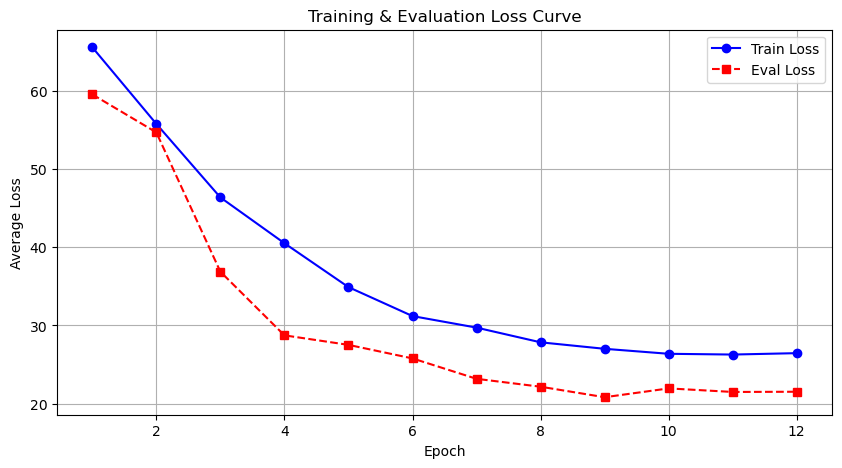

In [ ]:
SEED = 42
random.seed(SEED)  # Python random module
np.random.seed(SEED)  # NumPy random
torch.manual_seed(SEED)  # PyTorch random

# importlib.reload(PoseTransformer)

POSE_TRANSFORMER_LAYERS = 8
CROSS_TRANSFORMER_LAYERS = 8
CFG_DROPOUT_RATE = 0.1

# 5.1.0 uses SNR weighting
# 5.1.1 changes cross transformer layers from 6 to 4
# 6 introducd AE
# 7 introduced CFG | 7.1 used ACC of 16

checkpoint_path = f"model_saves/v7.0.0_TT_datapercent{PERCENT_TRAIN}_lr{LEARNING_RATE}_WD{WEIGHT_DECAY}_P{POSE_TRANSFORMER_LAYERS}C{CROSS_TRANSFORMER_LAYERS}_CFG{CFG_DROPOUT_RATE}_ACC{ACCUMULATION_STEPS}"

print("Loading Train dataset")
trainDataset = PoseTextDataset(src_dir=src_dir,setting="train",tokenizer=clip_tokenizer, joint_num=22, use_percentage=PERCENT_TRAIN)
trainDataLoader = DataLoader(trainDataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=collate_fn)
# persistent_workers=True,
# multiprocessing_context="spawn"
print("Loading Eval Dataset")
evalDataset = PoseTextDataset(src_dir=src_dir,setting="val",tokenizer=clip_tokenizer, joint_num=22, use_percentage=1)
evalDataLoader = DataLoader(evalDataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=collate_fn)
print("Dataset loading done")
pose_transformer = PoseTransformer.PoseTransformer(
    pose_dim=LATENT_DIM,
    embedding_dim=EMBEDDING_DIM,  # Match CLIP's embedding dimension
    num_heads=8,  # Number of attention heads
    num_layers=POSE_TRANSFORMER_LAYERS,  # Number of transformer layers
    dropout=CFG_DROPOUT_RATE,  # Dropout probability
    use_decoder=False
).to(device)

text_cross_transformer = PoseTransformer.CrossModalTransformer(
    pose_dim = EMBEDDING_DIM,
    memory_dim= EMBEDDING_DIM,
    embedding_dim=EMBEDDING_DIM,
    num_heads=8,
    num_layers=CROSS_TRANSFORMER_LAYERS,
    use_decoder=True
).to(device)

noise_predictor = nn.Sequential(
    ResidualMLPBlock(EMBEDDING_DIM),
    nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM),
    nn.SiLU(),
    nn.Linear(EMBEDDING_DIM, LATENT_DIM),
).to(device)

autoencoder = Autoencoder(POSE_FEATURES_DIM, LATENT_DIM).to(device)
ae_checkpoint = torch.load("model_saves\\autoencoder\\pose_ae_best.pth", map_location=device, weights_only=True)
# Verify dimensions match
if ae_checkpoint['input_dim'] != POSE_FEATURES_DIM:
        raise ValueError(f"AE Checkpoint input_dim ({ae_checkpoint['input_dim']}) doesn't match expected ({POSE_FEATURES_DIM})")
if ae_checkpoint['latent_dim'] != LATENT_DIM:
        raise ValueError(f"AE Checkpoint latent_dim ({ae_checkpoint['latent_dim']}) doesn't match expected ({LATENT_DIM})")

autoencoder.load_state_dict(ae_checkpoint['model_state_dict'])
print("Autoencoder weights loaded successfully.")
autoencoder.eval()
for param in autoencoder.parameters():
    param.requires_grad = False

pose_transformer.apply(init_weights_transformer)
text_cross_transformer.apply(init_weights_transformer)
noise_predictor.apply(init_weights_transformer) # Apply standard init first

# trajectory_cross_transformer = CrossModalTransformer(
#     pose_dim = EMBEDDING_DIM,
#     memory_dim= 60,
#     embedding_dim=EMBEDDING_DIM,
#     num_heads=8,
#     num_layers=6,
#     use_decoder=True
# )

trainer = Trainer({
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "train_dataloader": trainDataLoader,
    "eval_dataloader": evalDataLoader,
    "clip_text_model": clip_text_model,
    "clip_tokenizer": clip_tokenizer,
    "pose_transformer": pose_transformer,
    "text_cross_transformer": text_cross_transformer,
    # "trajectory_cross_transformer": trajectory_cross_transformer,
    "cfg_dropout_prob": 0.1,
    "autoencoder": autoencoder,
    "noise_predictor": noise_predictor,
    "pose_features_dim": POSE_FEATURES_DIM,
    "embedding_dim": EMBEDDING_DIM,
    "accumulation_steps": ACCUMULATION_STEPS,
}, checkpoint_path=checkpoint_path)
# Print for each model
print(f"Pose Transformer Parameters: {count_parameters(trainer.pose_transformer)}")
print(f"Text-Cross Transformer Parameters: {count_parameters(trainer.text_cross_transformer)}")
print(f"Noise Predictor Parameters: {count_parameters(trainer.noise_predictor)}")

# Total trainable parameters
total_params = sum([
    count_parameters(trainer.pose_transformer),
    count_parameters(trainer.text_cross_transformer),
    count_parameters(trainer.noise_predictor),
])
print(f"Total Trainable Parameters: {total_params}")
train_losses = []
eval_losses = []
best_eval_loss = float("inf")
best_model_state = None

for epoch in range(EPOCHS):
    train_loss = trainer.train()
    train_losses.append(train_loss)
    eval_loss = trainer.eval()
    eval_losses.append(eval_loss)
    print("Trian loss: ", train_loss, "Eval loss: ", eval_loss)
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_model_state = {
            "pose_transformer": trainer.pose_transformer.state_dict(),
            "text_cross_transformer": trainer.text_cross_transformer.state_dict(),
            "noise_predictor": trainer.noise_predictor.state_dict(),
        }

if best_model_state:
    torch.save(best_model_state, checkpoint_path)
    print(f"Best model saved with eval loss {best_eval_loss:.4f} at {checkpoint_path}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', linestyle='-', color='b', label="Train Loss")
plt.plot(range(1, EPOCHS + 1), eval_losses, marker='s', linestyle='--', color='r', label="Eval Loss")

plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training & Evaluation Loss Curve")
plt.legend()  # Show legend to differentiate train and eval losses
plt.grid()
plt.show()